# NLP 검색시스템

220419, wygo

# 0_Setting

In [1]:
## prepare data
# down the search code&data
!git clone https://github.com/airobotlab/lecture_3_advanced_text_search_system.git
!mv lecture_3_advanced_text_search_system/* .
!rm -rf lecture_3_advanced_text_search_system

Cloning into 'lecture_3_advanced_text_search_system'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (11/11), done.


In [2]:
!pip install faiss-gpu
!pip install -U sentence-transformers
!pip install streamlit

     |████████████████████████████████| 85.5 MB 78 kB/s 
     |████████████████████████████████| 79 kB 3.9 MB/s 
     |████████████████████████████████| 4.0 MB 11.0 MB/s 
     |████████████████████████████████| 1.2 MB 45.2 MB/s 
     |████████████████████████████████| 77 kB 8.0 MB/s 
     |████████████████████████████████| 895 kB 56.1 MB/s 
     |████████████████████████████████| 6.6 MB 43.7 MB/s 
     |████████████████████████████████| 596 kB 62.2 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=844c5ee96c8fdd1769519ccb703387c4dcd1672fff1858ec4da725dbdb99f2e1
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 10.1 MB 5.2 MB/s 
     

# 1_NLP 검색시스템 (K-means clustering)

- [ref](https://towardsdatascience.com/billion-scale-semantic-similarity-search-with-faiss-sbert-c845614962e2)
- [data](https://www.kaggle.com/datasets/therohk/million-headlines)

In [3]:
# ready = True
ready = False

In [4]:
%%time
input_file_path = 'data_nsmc.txt'

# NSMC 데이터 로드
import pandas as pd
df_data = pd.read_csv(input_file_path, sep='\t')
train_pair = [(row[1], row[2]) for _, row in df_data.iterrows() if type(row[1]) == str][:2000]  # nan 제거

#  문장 및 라벨 데이터 추출
train_data  = [pair[0] for pair in train_pair]
train_label = [pair[1] for pair in train_pair]
print('data loading done!')
print('문장: %s' %(train_data[:3]))
print('라벨: %s' %(train_label[:3]))

# subword 학습을 위해 문장만 따로 저장
with open('nsmc_sentence.txt', 'w', encoding='utf-8') as f:
    for line in train_data:
        f.write(line+'\n')

# subword 학습을 위해 문장만 따로 저장
with open('nsmc_sentence.txt', 'r', encoding='utf-8') as f:
    data = f.read().split('\n')
print(data[:3])

num_word_list = [len(sentence.split()) for sentence in data]
print('\n코퍼스 문장개수 | 평균/총 단어 갯수: %d / %.1f / %d' % (len(data), sum(num_word_list)/len(num_word_list), sum(num_word_list)))

data loading done!
문장: ['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '너무재밓었다그래서보는것을추천한다']
라벨: [0, 1, 0]
['아 더빙.. 진짜 짜증나네요 목소리', '흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나', '너무재밓었다그래서보는것을추천한다']

코퍼스 문장개수 | 평균/총 단어 갯수: 2001 / 7.6 / 15223
CPU times: user 11.8 s, sys: 170 ms, total: 11.9 s
Wall time: 14.6 s


In [5]:
## load
# !pip install faiss-gpu
# !pip install -U sentence-transformers
import numpy as np
import torch
import os
import pandas as pd
import faiss
import time
import pickle
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [6]:
## load language modeling as embedder
model = SentenceTransformer('jhgan/ko-sroberta-multitask')  # korean
# model = SentenceTransformer('distilbert-base-nli-mean-tokens')  # english

sentences = ["안녕하세요?", "한국어 문장 임베딩을 위한 버트 모델입니다."]
embeddings = model.encode(sentences)

print(embeddings)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/744 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/123 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/931 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/229 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/443M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/302 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/156 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/495k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/585 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/248k [00:00<?, ?B/s]

[[-0.37510443 -0.77338403  0.59277105 ...  0.57923514  0.32683483
  -0.6508965 ]
 [-0.09361701 -0.18191552 -0.19230805 ... -0.031658    0.3041255
  -0.26793626]]


In [7]:
%%time
if not ready:
    print('encoding start!')
    encoded_data = model.encode(data)  # 13min

    # save
    import pickle
    with open('encoded_data.pickle', 'wb') as f:
        pickle.dump(encoded_data, f, pickle.HIGHEST_PROTOCOL)
    
# load
with open('encoded_data.pickle', 'rb') as f:
    encoded_data = pickle.load(f)

print(encoded_data.shape)

encoding start!
(2001, 768)
CPU times: user 3.65 s, sys: 41 ms, total: 3.69 s
Wall time: 3.6 s


In [8]:
## faiss
index = faiss.IndexFlatIP(encoded_data.shape[1])  # 768
index = faiss.IndexIDMap2(index)
index.add_with_ids(encoded_data, np.array(range(0, len(encoded_data))).astype('int64'))

faiss.write_index(index, 'nsmc_index')  # save indexer

### search!!
검색시스템 서비스

In [9]:
index = faiss.read_index('nsmc_index')  # load indexer

def search(query, K=5):
    t = time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, K)
    print('totaltime: {}'.format(time.time()-t))
    return [data[_id] for _id in top_k[1].tolist()[0]]

In [10]:
query = str(input('댓글 검색: '))
results = search(query)
print('results :')
for result in results:
    print('\t', result)

댓글 검색: 이 영화 진짜 별로다..
totaltime: 0.0280153751373291
results :
	 진짜 짜증나는 영화..
	 정말쓰레기영화입니다
	 저질적이고 덜떨어진 영화..
	 이 영화 정말 별루예요. 결말이 이상해요....
	 내 생애 최악의 한국영화


# 2_k-means clustering

[ref](https://github.com/tkys/faiss_kmeans_spam/blob/master/faiss_k_means_clustering_spam_mail.ipynb)

In [11]:
K = 5  # Cluster 개수, 며 ㅊ개로 쪼갤것인가

niter =  20  
verbose =  True

start = time.time()
dimension = encoded_data.shape[1]  # 768
kmeans = faiss.Kmeans(dimension, K, niter=niter, verbose=verbose)

kmeans.train(encoded_data)

train_elapsed_time = time.time() - start
print('train_elapsed_time : %.1f sec'%train_elapsed_time)


train_elapsed_time : 0.1 sec


In [12]:
%%time
Distance, Index = kmeans.index.search(encoded_data, 3)

print('Index / Distance: %s / %s'%(Index.shape, Distance.shape))
print(Index)

Index / Distance: (2001, 3) / (2001, 3)
[[4 3 2]
 [4 0 2]
 [3 1 2]
 ...
 [3 4 2]
 [2 3 4]
 [3 1 2]]
CPU times: user 7.47 ms, sys: 66 µs, total: 7.54 ms
Wall time: 12.2 ms


In [13]:
## Save clustering result
df_text_k = pd.DataFrame(Index[:,0], columns=['k_index'])
df_result = df_data.join(df_text_k)
df_result.to_csv('result_clustering.csv',index=False, header=True)

df_result

,id,document,label,k_index
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,4.0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,4.0
2,10265843,너무재밓었다그래서보는것을추천한다,0,3.0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,4.0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,2.0
...,...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0,NaN
149996,8549745,평점이 너무 낮아서...,1,NaN
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0,NaN
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1,NaN


In [14]:
## check
cluster_idx = 2
df_result[df_result['k_index']==cluster_idx]

,id,document,label,k_index
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,2.0
7,9443947,별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단...,0,2.0
11,10217543,볼때마다 눈물나서 죽겠다90년대의 향수자극!!허진호는 감성절제멜로의 달인이다~,1,2.0
13,8628627,담백하고 깔끔해서 좋다. 신문기사로만 보다 보면 자꾸 잊어버린다. 그들도 사람이었다...,1,2.0
29,8322926,센스있는 연출력..탁월한 캐스팅..90년대의 향수.. 그래서 9점..,1,2.0
...,...,...,...,...
1982,10010858,나 월E가 고쳐지고 로봇같이 일할때 움.ㅠ우리 순수 LOVE손만 잡아봤으면 하는 로...,1,2.0
1987,5222537,"난 평소에 역사에 관심이잇고 이런 보물찾기, 미지의모험 열라좋아함 ㅋㅋ대박 ㅋㅋㅋ",1,2.0
1989,10064048,최고의 희극배우 찰리채플린 만세,0,2.0
1995,9840375,이런걸 우리나라에서 왜 개봉함?-_-,0,2.0


# 3_검색기반 챗봇

[ref](https://www.youtube.com/watch?v=VVArHrsxrYU)

In [15]:
df = pd.read_csv('data_wellness_dataset_original.csv')
df.head()

,구분,유저,챗봇,Unnamed: 3
0,감정/감정조절이상,제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.,감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.,NaN
1,감정/감정조절이상,더 이상 내 감정을 내가 컨트롤 못 하겠어.,저도 그 기분 이해해요. 많이 힘드시죠?,NaN
2,감정/감정조절이상,하루종일 오르락내리락 롤러코스터 타는 기분이에요.,"그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.",NaN
3,감정/감정조절이상,꼭 롤러코스터 타는 것 같아요.,NaN,NaN
4,감정/감정조절이상,롤러코스터 타는 것처럼 기분이 왔다 갔다 해요.,NaN,NaN


In [16]:
## 전처리
df_ = df.drop(columns=['Unnamed: 3'])
df_ = df_[~df_['챗봇'].isna()]
df_.head()

,구분,유저,챗봇
0,감정/감정조절이상,제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.,감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.
1,감정/감정조절이상,더 이상 내 감정을 내가 컨트롤 못 하겠어.,저도 그 기분 이해해요. 많이 힘드시죠?
2,감정/감정조절이상,하루종일 오르락내리락 롤러코스터 타는 기분이에요.,"그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요."
15,감정/감정조절이상/화,평소 다른 일을 할 때도 비슷해요. 생각한대로 안되면 화가 나고…그런 상황이 지속되...,화가 폭발할 것 같을 때는 그 자리를 피하는 것도 좋은 방법이라고 생각해요.
16,감정/감정조절이상/화,예전보다 화내는 게 과격해진 거 같아.,정말 힘드시겠어요. 화는 남에게도 스스로에게도 상처를 주잖아요.


In [17]:
# 문장 encoding
df_['embedding'] = df_['유저'].map(lambda x: list(model.encode(x)))
df_.to_csv('data_wellness_dataset.csv', index=False)

chatbot_class = df_['구분'].to_list()
chatbot_input = df_['유저'].to_list()
chatbot_output = df_['챗봇'].to_list()
chatbot_embedding = df_['embedding'].to_list()
assert len(chatbot_class) == len(chatbot_input) == len(chatbot_output) == len(chatbot_embedding)

df_

,구분,유저,챗봇,embedding
0,감정/감정조절이상,제 감정이 이상해진 것 같아요. 남편만 보면 화가 치밀어 오르고 감정 조절이 안되요.,감정이 조절이 안 될 때만큼 힘들 때는 없는 거 같아요.,"[-0.48060676, -0.29486904, 0.43790022, -0.6401..."
1,감정/감정조절이상,더 이상 내 감정을 내가 컨트롤 못 하겠어.,저도 그 기분 이해해요. 많이 힘드시죠?,"[-1.1561571, -0.1450625, 0.29490355, -0.673949..."
2,감정/감정조절이상,하루종일 오르락내리락 롤러코스터 타는 기분이에요.,"그럴 때는 밥은 잘 먹었는지, 잠은 잘 잤는지 체크해보는 것도 좋아요.","[-0.66520035, -0.08126819, 1.0945566, 0.105792..."
15,감정/감정조절이상/화,평소 다른 일을 할 때도 비슷해요. 생각한대로 안되면 화가 나고…그런 상황이 지속되...,화가 폭발할 것 같을 때는 그 자리를 피하는 것도 좋은 방법이라고 생각해요.,"[-0.7679061, 0.4652072, 0.5285072, -0.50760436..."
16,감정/감정조절이상/화,예전보다 화내는 게 과격해진 거 같아.,정말 힘드시겠어요. 화는 남에게도 스스로에게도 상처를 주잖아요.,"[-0.20277713, -0.37413934, 0.04053205, -0.8624..."
...,...,...,...,...
5196,치료이력/응급실,"그 사람이 응급실 의사한테 뭐라고 속닥거리니까, 저보고 갑자기 응급처치 끝났다고, ...",응급실이 있어서 다행이네요. 큰 문제는 없으신 거죠?,"[-0.18907836, -0.43884477, 0.3945907, -0.23626..."
5197,치료이력/응급실,파편이 튀어서 그 때 저도 응급실 가서 치료 받기도 했고…,응급실에 가셨다니 정말 놀랐어요. 아무 문제 없으신가요? 걱정 되네요.,"[-0.5251449, -0.46516114, -0.2698541, -0.35069..."
5213,현재상태/증상악화,지금 상태가 너무 안 좋아서 학교 안 나가고 있어요.,상태가 더 안 좋아지셨군요. 걱정이 되네요.,"[-0.6814685, -0.11450251, 0.038396865, -0.2865..."
5214,현재상태/증상악화,진짜 심해진 거 같긴 해요.,정말 힘드시겠어요. 지금도 증상이 심하신가요?,"[-0.18133016, -0.1098092, -0.21448681, -0.4437..."


In [18]:

## faiss
encoded_data = np.array(chatbot_embedding)
index = faiss.IndexFlatIP(encoded_data.shape[1])  # 768
index = faiss.IndexIDMap2(index)
index.add_with_ids(encoded_data, np.array(range(0, len(encoded_data))).astype('int64'))

faiss.write_index(index, 'chatbot_index')  # save indexer

### search!!
검색기반 챗봇 서비스

In [19]:
index = faiss.read_index('chatbot_index')  # load indexer

def search(query, K=5):
    t = time.time()
    query_vector = model.encode([query])
    top_k = index.search(query_vector, K)
    print('totaltime: {}'.format(time.time()-t))
    return [data[_id] for _id in top_k[1].tolist()[0]]

In [20]:
query = '요즘 머리가 아프고 너무 힘들어'

def search(query, K=5):
    t = time.time()
    query_vector = model.encode([query])
    Distance, Index = index.search(query_vector, K)
    final_index = Index.tolist()[0]
    print('totaltime: %.1f sec'%(time.time()-t))

    return final_index

search(query)

totaltime: 0.0 sec


[965, 268, 954, 956, 10]

In [21]:
query = str(input('검색기반 챗봇: '))
result_idx = search(query)
print('results :')
for idx in result_idx:
    print('\t=> %s (%s)'%(chatbot_output[idx], chatbot_class[idx]))

검색기반 챗봇: 요즘 머리가 아프로 너무 힘들어...
totaltime: 0.0 sec
results :
	=> 으으, 머리가 아프면 정말 힘들죠. 그 마음 정말 이해해요. (증상/편두통)
	=> 정말 힘들고 스트레스 받으시겠어요. 따뜻한 물에 샤워를 추천해드릴게요. (감정/힘듦/스트레스)
	=> 정말 힘드셨겠어요. 지금은 안 아프신가요? (증상/통증)
	=> 그러셨군요. 저도 마음이 아프네요. (감정/괴로움)
	=> 너무 걱정하지 마세요. 현대의학을 믿자구요. (감정/걱정/건강문제)


# 4_streamlit 에서 서비스
[ref](https://zzsza.github.io/mlops/2021/02/07/python-streamlit-dashboard/)

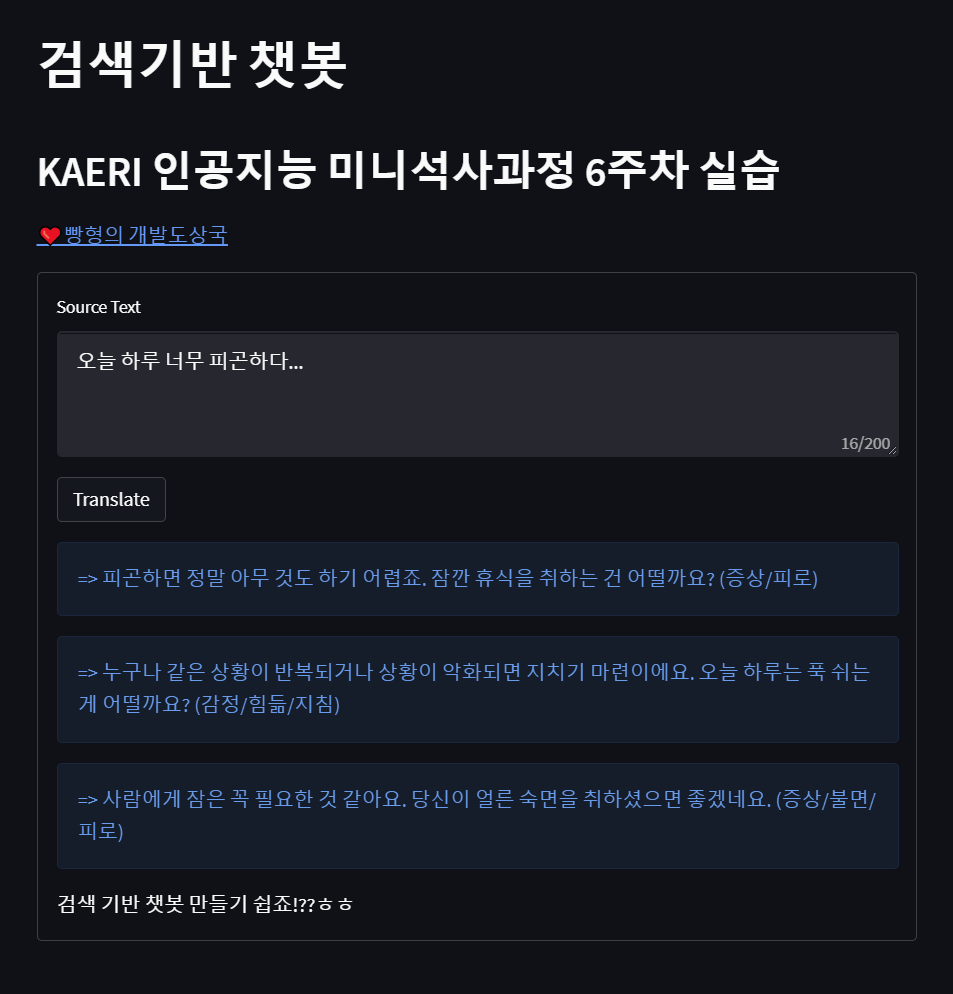

In [22]:
from IPython.display import Image
Image('검색기반 챗봇.jpg')

In [23]:
# !streamlit run chatbot.py